# Web Scrapper Project


## Importing Libraries

In [66]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json

## Website To Scrape

In [67]:
topics_url = "https://github.com/topics"

## Calling The Website

In [68]:
response = requests.get(topics_url)

In [69]:
response.status_code

200

## Parsing The Website

In [70]:
soup = BeautifulSoup(response.text, 'html.parser')
selection =  'f3 lh-condensed mb-0 mt-1 Link--primary'
topic_title_p_tags = soup.find_all('p', class_=selection)
topic_description_p_tags = soup.find_all('p', class_='f5 color-fg-muted mb-0 mt-1')


## Helper Functions
#### These functions will help us to get the topic page, and from the topic page get the repository information.

In [71]:
base_url = "https://github.com"

def get_topic_page(topic_Url):
    response = requests.get(topic_Url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_Url))
    return BeautifulSoup(response.text, 'html.parser')

def get_repo_info(h3_tag, star_tag):
    a_tags = h3_tag.find_all('a')
    author = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = star_tag.text.strip()
    return author, repo_name, repo_url, stars

def get_topic_repos(topic_soup):
    repo_tags = topic_soup.find_all('article', class_='border rounded color-shadow-small color-bg-subtle my-4')
    star_tags = topic_soup.find_all('span', class_='Counter js-social-count')

    topic_repos = []
    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i].find('h3'), star_tags[i])
        topic_repos.append(repo_info)
    return topic_repos

## Scrapping Repositories from each Topic
#### Here we will loop through each topic, get the topic URL, and then use our helper functions to get the top repositories and their information.

In [72]:
all_repos_data = []
for title, desc in zip(topic_title_p_tags, topic_description_p_tags):
    parent_a = title.find_parent('a')
    href = parent_a['href'] if parent_a and parent_a.has_attr('href') else None
    topic_title = title.text.strip()
    topic_desc = desc.text.strip()
    print("Scraping Topic:", topic_title)

    if href:
        topic_url = base_url + href

        topic_soup = get_topic_page(topic_url)
        topic_repos = get_topic_repos(topic_soup)

        for author, repo_name, repo_url, stars in topic_repos:
            repo_dict = {
                'Topic Title': topic_title,
                'Topic Description': topic_desc,
                'Author': author,
                'Repository Name': repo_name,
                'Stars': stars,
                'Repository URL': repo_url
            }
            all_repos_data.append(repo_dict)

print("\nScraping complete.")

Scraping Topic: Awesome Lists
Scraping Topic: Chrome
Scraping Topic: Code quality
Scraping Topic: Compiler
Scraping Topic: CSS
Scraping Topic: Database
Scraping Topic: Front end
Scraping Topic: JavaScript
Scraping Topic: Node.js
Scraping Topic: npm
Scraping Topic: Project management
Scraping Topic: Python
Scraping Topic: React
Scraping Topic: React Native
Scraping Topic: Scala
Scraping Topic: TypeScript

Scraping complete.


## Visual Representation of Data
#### Using pandas to create a DataFrame for a clean, table-like view of the scraped data.

In [73]:
repos_df = pd.DataFrame(all_repos_data)
repos_df

,Topic Title,Topic Description,Author,Repository Name,Stars,Repository URL
0,Awesome Lists,An awesome list is a list of awesome things cu...,sindresorhus,awesome,407k,https://github.com/sindresorhus/awesome
1,Awesome Lists,An awesome list is a list of awesome things cu...,vinta,awesome-python,264k,https://github.com/vinta/awesome-python
2,Awesome Lists,An awesome list is a list of awesome things cu...,awesome-selfhosted,awesome-selfhosted,253k,https://github.com/awesome-selfhosted/awesome-...
3,Awesome Lists,An awesome list is a list of awesome things cu...,trimstray,the-book-of-secret-knowledge,190k,https://github.com/trimstray/the-book-of-secre...
4,Awesome Lists,An awesome list is a list of awesome things cu...,avelino,awesome-go,155k,https://github.com/avelino/awesome-go
...,...,...,...,...,...,...
315,TypeScript,TypeScript is a typed superset of JavaScript t...,prettier,prettier,51.1k,https://github.com/prettier/prettier
316,TypeScript,TypeScript is a typed superset of JavaScript t...,DefinitelyTyped,DefinitelyTyped,50.5k,https://github.com/DefinitelyTyped/DefinitelyT...
317,TypeScript,TypeScript is a typed superset of JavaScript t...,TanStack,query,47k,https://github.com/TanStack/query
318,TypeScript,TypeScript is a typed superset of JavaScript t...,typescript-cheatsheets,react,46.7k,https://github.com/typescript-cheatsheets/react


## Store the data in a JSON file
#### The scraped data is written to `github_topics_repos.json` on your local storage.

In [74]:
with open('github_topics_repos.json', 'w', encoding='utf-8') as f:
    json.dump(all_repos_data, f, indent=4)

print("Data saved to github_topics_repos.json")

Data saved to github_topics_repos.json


## Data Analytics and Visualization
#### Here we will perform some basic data analysis and create visualizations on our scraped data.

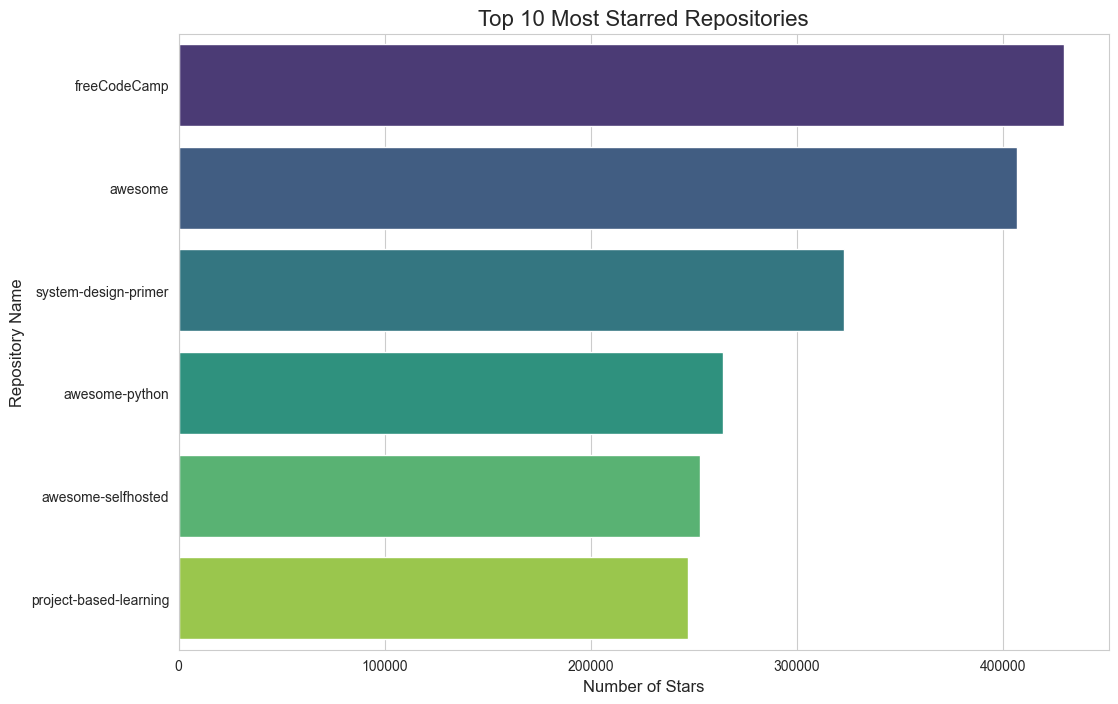

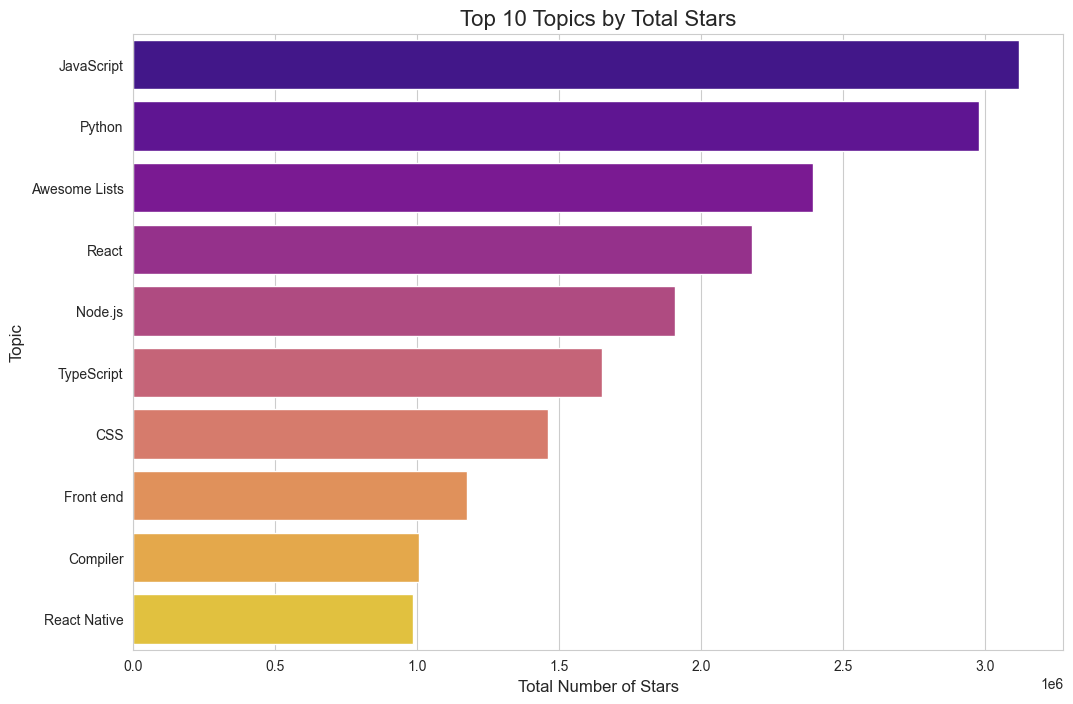

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def convert_stars_to_numeric(stars_str):
    stars_str = stars_str.strip()
    if 'k' in stars_str.lower():
        return int(float(stars_str.lower().replace('k', '')) * 1000)
    return int(stars_str.replace(',', ''))

repos_df['Stars_numeric'] = repos_df['Stars'].apply(convert_stars_to_numeric)

top_10_repos = repos_df.sort_values(by='Stars_numeric', ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x='Stars_numeric', y='Repository Name', data=top_10_repos, palette='viridis', hue='Repository Name', legend=False)
plt.title('Top 10 Most Starred Repositories', fontsize=16)
plt.xlabel('Number of Stars', fontsize=12)
plt.ylabel('Repository Name', fontsize=12)
plt.show()

top_topics = repos_df.groupby('Topic Title')['Stars_numeric'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_topics.values, y=top_topics.index, palette='plasma', hue=top_topics.index, legend=False)
plt.title('Top 10 Topics by Total Stars', fontsize=16)
plt.xlabel('Total Number of Stars', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.show()
